<a href="https://colab.research.google.com/github/inahre/sketch_to_reality/blob/main/sketch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title installs

!pip install diffusers
!pip install Pillow
!pip install transformers
!pip install -qq accelerate
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes
!pip install huggingface_hub
!pip install pandas

In [ ]:
#@title imports

import PIL
import os
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from diffusers import DiffusionPipeline

from google.colab import drive

from argparse import Namespace
import itertools
import math
from contextlib import nullcontext
import random

import torch.nn.functional as F
import torch.utils.checkpoint
import bitsandbytes as bnb

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


#from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=zywt5VQ30O3i

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
#@title mount google drive

drive.mount('/content/gdrive') #to get access to google drive content

Mounted at /content/gdrive


In [ ]:
#@title Sketch Generation

#model name for sketch generation

sketch_model_name = "stabilityai/stable-diffusion-2" #defines pre-trained model used

#source: https://huggingface.co/stabilityai/stable-diffusion-2

In [ ]:
#@title Load necessary models and create wrapper for stable diffusion using diffusers library for fine-tuning
text_encoder = CLIPTextModel.from_pretrained(
    sketch_model_name, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    sketch_model_name, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    sketch_model_name, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    sketch_model_name, subfolder="tokenizer",
)

In [ ]:
#@title Sketches Pre-Processing

#define sketch path

sketch_path = "/content/gdrive/MyDrive/Thesis_Project/data/sketches"

# create path to original csv file

sketch_csv = "/content/gdrive/MyDrive/Thesis_Project/data/sketch_descriptions.csv"

In [ ]:
#flipping the sketches
os.makedirs(sketch_path, exist_ok=True)

def flip_image(sketch_path):
    with Image.open(sketch_path) as img:
        # Flip the image horizontally
        flipped_image = img.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

# Loop through all photos in the image folder
for image_name in os.listdir(sketch_path):
    if image_name.lower().endswith((".jpg", ".jpeg", ".png")):
        image_file_path = os.path.join(sketch_path, image_name)

        # Flip the image
        flipped_image = flip_image(image_file_path)

        # Save the flipped image
        flipped_image.save(os.path.join(sketch_path, f"flipped_{image_name}"))

#sources: with https://pillow.readthedocs.io/en/stable/reference/Image.html - pillow documentation; (https://docs.python.org/3/library/os.html) - os documentation

In [ ]:
#set target size for resizing (if needed)
target_size = (768, 768)

In [ ]:
#@title resizing function with Pillow and os (in case it's needed)

# This resizing function is left here for reference.
# All resizing is currently handled within the Dataset class using transforms.

#def aspect_ratio_resize(image_path, target_size):
#    image = Image.open(image_path)
 #   width, height = image.size
    # Calculate new dimensions while preserving aspect ratio
##
  #  if width > height:
   #     target_height = int(target_size[0] * (height/width))
    #    target_width = target_size[0]
    #else:
     #   target_width = int(target_size[1] * (width/height))
      #  target_height = target_size[1]
#
 #   # Resize image
  #  resized_image = image.resize((target_width, target_height), Image.LANCZOS)

    #for padding
    # Create a new blank image with the target size
   # new_image = Image.new("RGB", target_size)
    # Calculate the position to paste the resized image with padding
    #x_offset = (target_size[0] - target_width) // 2 #horizontal offset
    #y_offset = (target_size[1] - target_height) // 2 #vertical offset
    # Paste the resized image onto the blank image with padding
    #new_image.paste(resized_image, (x_offset, y_offset))

    #return new_image

# Loop through all photos in the image folder
#for image_name in os.listdir(image_path):
 #   if image_name.lower().endswith((".jpg", ".jpeg", ".png")):
  #      image_file_path = os.path.join(image_path, image_name)

        # Resizing and padding
   #     resized_image = aspect_ratio_resize(image_file_path, target_size)

        # Save the new image
    #    resized_image.save(os.path.join(output_folder, f"resized_{image_name}"))

#sources: with https://pillow.readthedocs.io/en/stable/reference/Image.html - pillow documentation; (https://docs.python.org/3/library/os.html) - os documentation

In [ ]:
df = pd.read_csv(sketch_csv)

print(df.columns)

Index(['sketch_path', 'description'], dtype='object')


In [ ]:
#@title updating the descriptions in the csv file

#Load existing CSV
df = pd.read_csv(sketch_csv)

#Create set of already-existing paths for fast lookup
existing_paths = set(df['sketch_path'])

#create dataframe for flipped images
flipped_entries = []
for image_name in os.listdir(sketch_path):
    if image_name.lower().endswith((".jpg", ".jpeg", ".png")) and image_name.startswith('flipped_'):
        flipped_path = os.path.join(sketch_path, image_name)

        # Skip if already in CSV
        if flipped_path in existing_paths:
            continue

        # Extract original image name
        original_name = image_name.replace('flipped_', '')
        description = df.loc[df['sketch_path'].str.contains(original_name), 'description'].values[0]
        flipped_entries.append([flipped_path, description])

#Convert list to DataFrame
flipped_df = pd.DataFrame(flipped_entries, columns=['sketch_path', 'description'])

# Combine and save only if there are new flipped entries
if not flipped_df.empty:
    updated_df = pd.concat([df, flipped_df], ignore_index=True)
    updated_df.to_csv(sketch_csv, index=False)
    print(f"Appended {len(flipped_df)} new flipped entries to CSV.")
else:
    print("No new flipped images to add.")

In [ ]:
# Define the path to your CSV file and the folder containing the images
csv_path = '/content/gdrive/MyDrive/Thesis_Project/data/sketch_descriptions.csv'
images_path = '/content/gdrive/MyDrive/Thesis_Project/data/sketches/'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Update paths in the 'image_path' column
df['sketch_path'] = df['sketch_path'].apply(lambda x: os.path.join(sketch_path, x))

# Save the updated DataFrame back to a CSV file
df.to_csv(csv_path, index=False)

#sources: Pandas - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html ; https://docs.python.org/3/library/os.html

In [ ]:
# redefine paths

sketch_path = "/content/gdrive/MyDrive/Thesis_Project/data/sketches"
sketch_csv = "/content/gdrive/MyDrive/Thesis_Project/data/sketch_descriptions.csv"

In [ ]:
#@title Training Set-Up for Sketches

#instance_prompt to define style

#unique identifier for thesis
instance_prompt = "TR-GE thesis project" #@param {type:"string"}
#Check the prior_preservation option if you would like class of the concept to be preserved.
#not as relevant for style transfer

prior_preservation = False

In [ ]:
#Set up prompt functions
#using code from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V
#parts adjusted to fit the use case

from pathlib import Path
from torchvision import transforms

class MannequinSketches(Dataset): #adjusted from AI for media project to include descriptions from the csv file
    def __init__(
        self,
        sketch_csv, #csv for individual sketch descriptions added
        image_dir,
        tokenizer,
        instance_prompt,
        size=512,
        center_crop=False,

    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.instance_prompt = instance_prompt

        # Load the CSV file containing image paths and descriptions
        self.data_frame = pd.read_csv(sketch_csv)

        # Ensure the image directory exists
        self.image_dir = Path(sketch_path)
        if not self.image_dir.exists():
            raise ValueError("Image directory doesn't exist.")

        # Create a list of image paths from the CSV file
        self.image_paths = [Path(img_path) if os.path.isabs(img_path) else self.image_dir / img_path for img_path in self.data_frame['sketch_path']]
        self.descriptions = self.data_frame['description']
        self._length = len(self.image_paths)


        # Define image transformations
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("RGB")
        image = self.image_transforms(image)

        description = self.descriptions.iloc[index]
        prompt_ids = self.tokenizer(
            description,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids


        return {'image': image, 'prompt_ids': prompt_ids, 'instance_prompt': self.instance_prompt}

#source: https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V - all training code adapted and adjusted from this

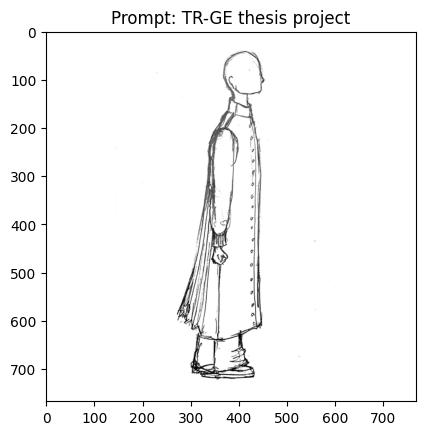

Description: Side view of a pencil-sketched mannequin of slender build wearing a layered outfit: A long, sleeveless button-up vest made of felted wool with a thick satin pleated back over a knit jumper and baggy trousers. The outfit combines textured layers with a relaxed fit, showcasing a mix of materials and styles.


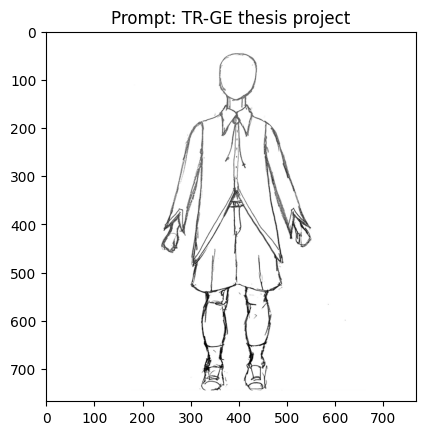

Description: Front view of a pencil-sketched mannequin of athletic build in an alt-chic outfit: A light silk button-up shirt and large above-knee shorts. The outfit is tailored yet flowy.


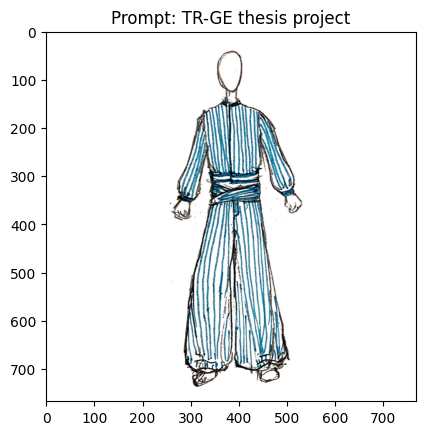

Description: Front view of a pencil-sketched and slightly coloured in mannequin of lean build in a bohemian-chic outfit: A denim cropped bomber jacket with turquoise and white vertical stripes, paired with baggy denim trousers featuring a crossed waistband. The outfit is oversized but tailored at the waist.


In [ ]:
#check whether data is set up correctly

sketch_csv = sketch_csv
image_dir = sketch_path
instance_prompt = instance_prompt

# dataset setup
dataset = MannequinSketches(
    sketch_csv=sketch_csv,
    image_dir=image_dir,
    tokenizer=tokenizer,
    instance_prompt=instance_prompt,
    size=768,
    center_crop=True
)

#samples
for i in range(3):  # Test with first 3 images
    sample = dataset[i]

    # Display image
    img = sample['image'].permute(1, 2, 0).numpy()  #source: https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch
    img = (img * 0.5) + 0.5  # Undo normalization #consulted chatgpt as image output colours were dark
    plt.imshow(img)
    plt.title(f"Prompt: {sample['instance_prompt']}")
    plt.show()

    # Print description
    print(f"Description: {dataset.descriptions.iloc[i]}")

In [ ]:
#Setting up training arguments as by https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V

#adjusted the hyperparameters as based on knowledge about learning rate, batch size, gradient accumulation
from argparse import Namespace
args = Namespace(
    model_name=sketch_model_name,
    resolution=768,
    center_crop=False, #images already preprocessed by pre-processing function and Adobe Photoshop
    train_text_encoder=False,
    instance_data_dir=sketch_path,
    instance_prompt=instance_prompt,
    learning_rate=1e-06,
    max_train_steps=1500,
    #if not satisfied with results, will up this
    save_steps=200,
    train_batch_size=4,
    gradient_accumulation_steps=2,
    #https://learn.rundiffusion.com/dreambooth-training/#:~:text=Batch%20size%3A&text=If%20you%20have%20a%20small,should%20be%20kept%20quite%20low and https://github.com/d8ahazard/sd_dreambooth_extension/wiki/Batch-Size
    #higher batch size is more relevant for style transfer, but also leads to overfitting
    #set at 2 and 2 initially to have effective batch size 4
    max_grad_norm=1.0,
    mixed_precision="fp16", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation,
    #removed class variables
    lr_scheduler="constant",
    lr_warmup_steps=0, #don't need this because we're fine-tuning on a well-trained model. Hence less risk of instability during training (https://jefsnacker.medium.com/dreambooth-hyperparameter-guide-d8b7cd264245)
    output_dir="/content/gdrive/MyDrive/Thesis_Project/sketch_checkpoints",
)

In [ ]:
#training function adapted from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V and modified
from accelerate.utils import set_seed

def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
    # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
    # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.model_name, subfolder="scheduler")

    train_dataset = MannequinSketches(
        sketch_csv = sketch_csv, #added for sketch descriptions
        image_dir=sketch_path,
        instance_prompt=args.instance_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["prompt_ids"] for example in examples]
        pixel_values = [example["image"] for example in examples]


        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            return_tensors="pt",
            max_length=tokenizer.model_max_length
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cuda")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean") #just defined loss rather than using if-else, as prior preservation not relevant in use case
                accelerator.backward(loss)


                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = DiffusionPipeline.from_pretrained(
                            args.model_name,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = DiffusionPipeline.from_pretrained(
            args.model_name,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#Run the Training Job (directly adapted from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=zywt5VQ30O3i)
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

In [ ]:
#load model checkpoint from gdrive

model_path = "/content/gdrive/MyDrive/Thesis_Project/sketch_checkpoints/checkpoint-800"
pipe = DiffusionPipeline.from_pretrained(model_path)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

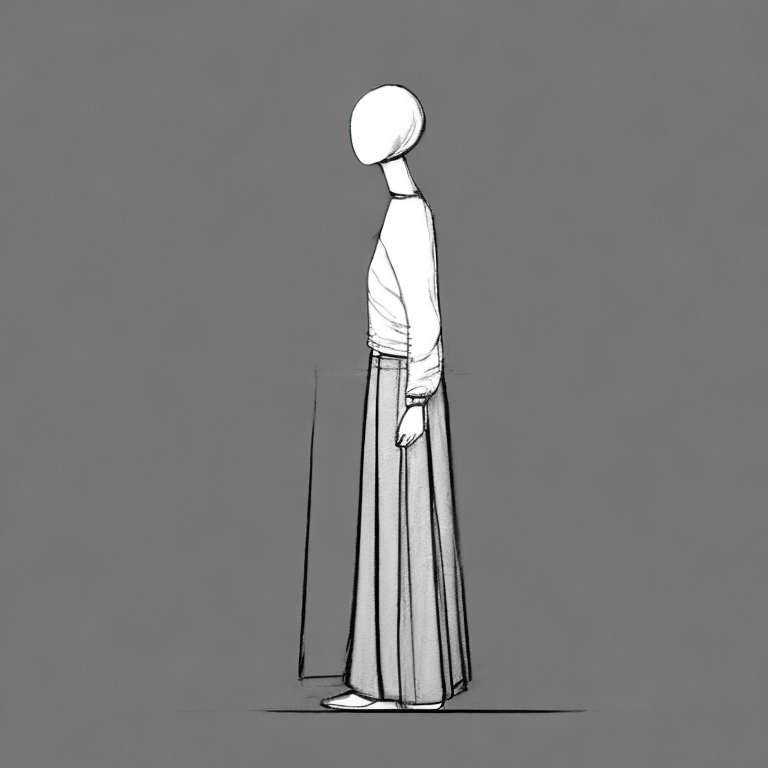

In [ ]:
#Run Stable Diffusion pipeline

prompt = "Side view of a pencil-sketched tall mannequin in a classic outfit: A lightweight loose-fitted long-sleeved cotton jersey t-shirt with a crew neckline. A long skirt with puffs composed of asymmetrical panels that are gathered at the edges." #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid